In [262]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from pandas.api.types import CategoricalDtype




In [263]:
# Cargar el dataset
df = pd.read_csv("train.csv")

In [264]:
# Información general
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 912 entries, 0 to 911
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                912 non-null    int64  
 1   laptop_ID         912 non-null    int64  
 2   Company           912 non-null    object 
 3   Product           912 non-null    object 
 4   TypeName          912 non-null    object 
 5   Inches            912 non-null    float64
 6   ScreenResolution  912 non-null    object 
 7   Cpu               912 non-null    object 
 8   Ram               912 non-null    object 
 9   Memory            912 non-null    object 
 10  Gpu               912 non-null    object 
 11  OpSys             912 non-null    object 
 12  Weight            912 non-null    object 
 13  Price_euros       912 non-null    float64
dtypes: float64(2), int64(2), object(10)
memory usage: 99.9+ KB
None


In [265]:
# Estadísticas descriptivas
print(df.describe())

                id    laptop_ID      Inches  Price_euros
count   912.000000   912.000000  912.000000   912.000000
mean    645.091009   666.192982   15.011404  1108.122873
std     380.313813   384.873846    1.411744   714.597741
min       0.000000     1.000000   10.100000   174.000000
25%     319.750000   330.500000   14.000000   589.000000
50%     636.500000   673.500000   15.600000   949.000000
75%     980.250000   998.500000   15.600000  1458.500000
max    1302.000000  1320.000000   18.400000  6099.000000


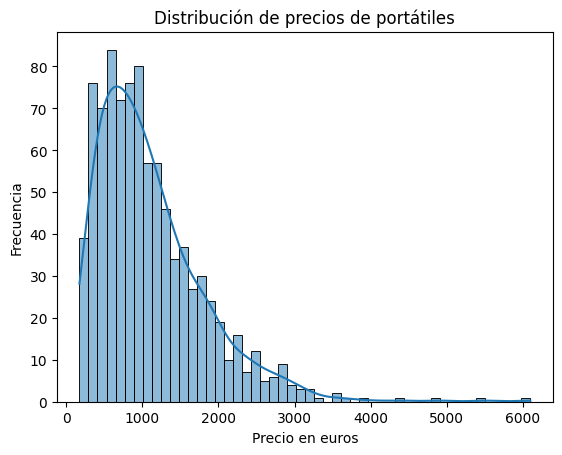

In [266]:
# Histograma de precios
sns.histplot(df["Price_euros"], bins=50, kde=True)
plt.xlabel("Precio en euros")
plt.ylabel("Frecuencia")
plt.title("Distribución de precios de portátiles")
plt.show()


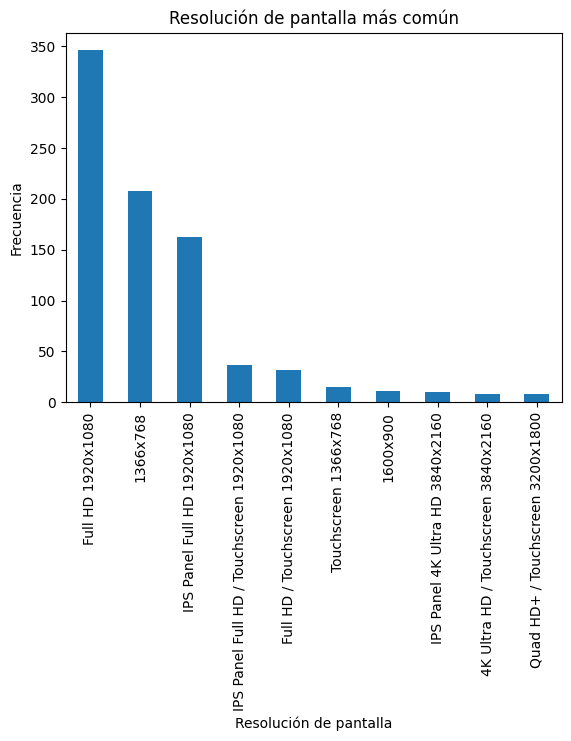

In [267]:
df["ScreenResolution"].value_counts().head(10).plot(kind='bar')
plt.xlabel("Resolución de pantalla")    
plt.ylabel("Frecuencia")
plt.title("Resolución de pantalla más común")
plt.show()
# Gráfico de barras de marcas más comunes

# EVALUACIÓN DEL DATASET:
De acuerdo a lo observado, gran parte de las variables son de tipo object, lo que nos motiva a evaluar el dataset y considerar transformar, de acuerdo a su naturaleza, las variables que sean susceptibles de ser transformadas en numéricas.

In [268]:
# Eliminar columnas irrelevantes
df.drop(["id", "laptop_ID", "Product"], axis=1, inplace=True)

In [269]:
# Entre las variables que intentaremos trasnformar están:
# Weight, Ram, y Memory

# Convertir 'Ram' a número
df["Ram"] = df["Ram"].str.replace("GB", "").astype(int)

# Convertir 'Weight' a número
df["Weight"] = df["Weight"].str.replace("kg", "").astype(float)



In [270]:
import re
# Procesamos la columna 'Memory'
def split_memory(mem):
    mem = mem.replace("Flash Storage", "Flash_Storage")
    parts = mem.split("+")
    result = {"HDD": 0, "SSD": 0, "Hybrid": 0, "Flash_Storage": 0}

    for part in parts:
        part = part.strip()

        # Buscar el tamaño y tipo con regex
        size_match = re.search(r"(\\d+(\\.\\d+)?)(GB|TB)", part)
        if not size_match:
            continue  # omitir partes no reconocibles

        size = float(size_match.group(1))
        unit = size_match.group(3)
        if unit == "TB":
            size *= 1024  # convertir a GB

        if "HDD" in part:
            result["HDD"] += size
        elif "SSD" in part:
            result["SSD"] += size
        elif "Hybrid" in part:
            result["Hybrid"] += size
        elif "Flash_Storage" in part:
            result["Flash_Storage"] += size

    return pd.Series(result)

df = pd.concat([df, df["Memory"].apply(split_memory)], axis=1)
df.drop("Memory", axis=1, inplace=True)


In [271]:
# Procesar la columna 'ScreenResolution' 
# Convertimos en Binaria (dummy) las resoluciones de pantalla especiales
df["Touchscreen"] = df["ScreenResolution"].str.contains("Touchscreen").astype(int)
df["IPS"] = df["ScreenResolution"].str.contains("IPS").astype(int)

# Extraer resolución numérica
def extract_resolution(res):
    if pd.isnull(res):
        return pd.Series({"X_res": None, "Y_res": None})
    match = re.search(r"(\d+)x(\d+)", str(res))
    if match:
        return pd.Series({"X_res": int(match.group(1)), "Y_res": int(match.group(2))})
    else:
        return pd.Series({"X_res": None, "Y_res": None})

df = pd.concat([df, df["ScreenResolution"].apply(extract_resolution)], axis=1)

# Crear variable ordinal ScreenQuality
def categorize_screen_quality(row):
    x = row["X_res"]
    y = row["Y_res"]
    if pd.isnull(x) or pd.isnull(y):
        return "Unknown"
    elif x < 1280 or y < 800:
        return "Low"
    elif x <= 1920 and y <= 1080:
        return "Full HD"
    elif x <= 2560 and y <= 1600:
        return "2K"
    elif x >= 3840 and y >= 2160:
        return "4K"
    else:
        return "Full HD"

df["ScreenQuality"] = df.apply(categorize_screen_quality, axis=1)

# Convertir a ordinal con categorías ordenadas
from pandas.api.types import CategoricalDtype
quality_order = CategoricalDtype(categories=["Low","Full HD", "2K", "4K"], ordered=True)
df["ScreenQuality"] = df["ScreenQuality"].astype(quality_order)

# Codificar ordinalmente como entero (opcional)
#df["ScreenQuality_Ordinal"] = df["ScreenQuality"].cat.codes

# Finalmente eliminamos columnas que ya no se necesiten
df.drop(["ScreenResolution", "X_res", "Y_res"], axis=1, inplace=True)

<Axes: xlabel='ScreenQuality'>

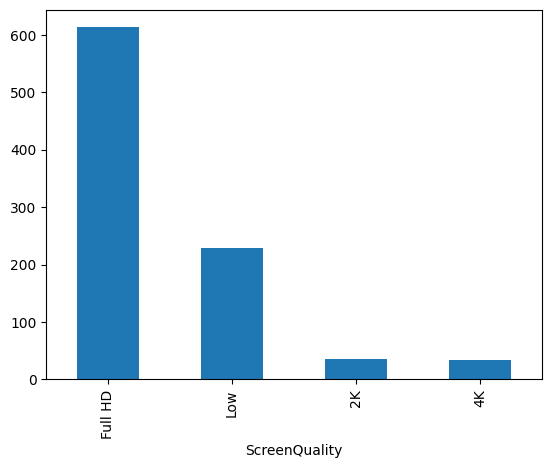

In [272]:
df.ScreenQuality.value_counts().plot(kind='bar')

In [273]:
print(df["ScreenQuality"].value_counts(dropna=False))

ScreenQuality
Full HD    613
Low        229
2K          36
4K          34
Name: count, dtype: int64


In [274]:
df.columns


Index(['Company', 'TypeName', 'Inches', 'Cpu', 'Ram', 'Gpu', 'OpSys', 'Weight',
       'Price_euros', 'HDD', 'SSD', 'Hybrid', 'Flash_Storage', 'Touchscreen',
       'IPS', 'ScreenQuality'],
      dtype='object')

In [275]:
def extract_cpu_speed(cpu_str):
    match = re.search(r"(\d+[.,]?\d*)GHz", cpu_str)
    if match:
        return float(match.group(1).replace(",", "."))
    else:
        return np.nan

df["Cpu_speed_GHz"] = df["Cpu"].apply(extract_cpu_speed)

In [ ]:
# Procesar la columna 'Cpu'
df["Cpu_brand"] = df["Cpu"].apply(lambda x: x.split()[0])
df["Cpu_model"] = df["Cpu"].apply(lambda x: " ".join(x.split()[1:3]))
df.drop("Cpu", axis=1, inplace=True)


In [277]:
df["Cpu_speed_GHz"].unique()
df["Cpu_speed_GHz"].info()


<class 'pandas.core.series.Series'>
RangeIndex: 912 entries, 0 to 911
Series name: Cpu_speed_GHz
Non-Null Count  Dtype  
--------------  -----  
912 non-null    float64
dtypes: float64(1)
memory usage: 7.3 KB


In [231]:
# Procesar la columna 'Gpu'
df["Gpu_brand"] = df["Gpu"].apply(lambda x: x.split()[0])
df.drop("Gpu", axis=1, inplace=True)


In [232]:
# Codificar variables categóricas
categorical_cols = ["Company", "TypeName", "OpSys", "Cpu_brand", "Cpu_model", "Gpu_brand","ScreenQuality"]
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [233]:
# Guardar DataFrame procesado
df.to_csv("laptops_preprocesado.csv", index=False)

In [234]:
df.columns

Index(['Inches', 'Ram', 'Weight', 'Price_euros', 'HDD', 'SSD', 'Hybrid',
       'Flash_Storage', 'Touchscreen', 'IPS', 'Cpu_speed_GHz', 'Company_Apple',
       'Company_Asus', 'Company_Chuwi', 'Company_Dell', 'Company_Fujitsu',
       'Company_Google', 'Company_HP', 'Company_Huawei', 'Company_LG',
       'Company_Lenovo', 'Company_MSI', 'Company_Mediacom',
       'Company_Microsoft', 'Company_Razer', 'Company_Samsung',
       'Company_Toshiba', 'Company_Vero', 'Company_Xiaomi', 'TypeName_Gaming',
       'TypeName_Netbook', 'TypeName_Notebook', 'TypeName_Ultrabook',
       'TypeName_Workstation', 'OpSys_Chrome OS', 'OpSys_Linux',
       'OpSys_Mac OS X', 'OpSys_No OS', 'OpSys_Windows 10',
       'OpSys_Windows 10 S', 'OpSys_Windows 7', 'OpSys_macOS',
       'Cpu_brand_Intel', 'Cpu_model_A10-Series A10-9620P',
       'Cpu_model_A12-Series 9700P', 'Cpu_model_A12-Series 9720P',
       'Cpu_model_A6-Series 9220', 'Cpu_model_A6-Series A6-9220',
       'Cpu_model_A8-Series 7410', 'Cpu_model_A

Mean Absolute Error: 194.42187318544535
Mean Squared Error: 108560.24585157695
R² score: 0.7486485019544559


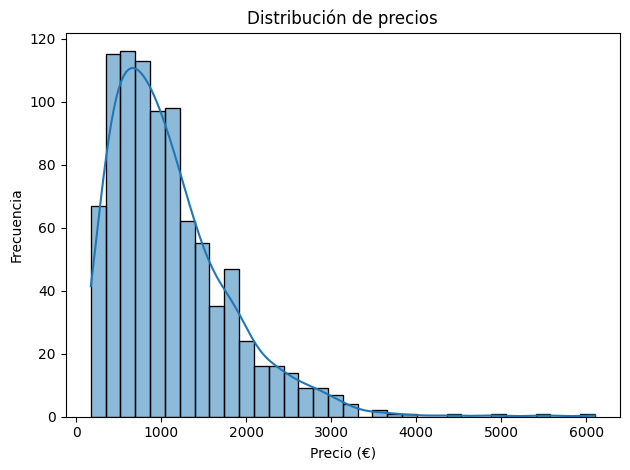

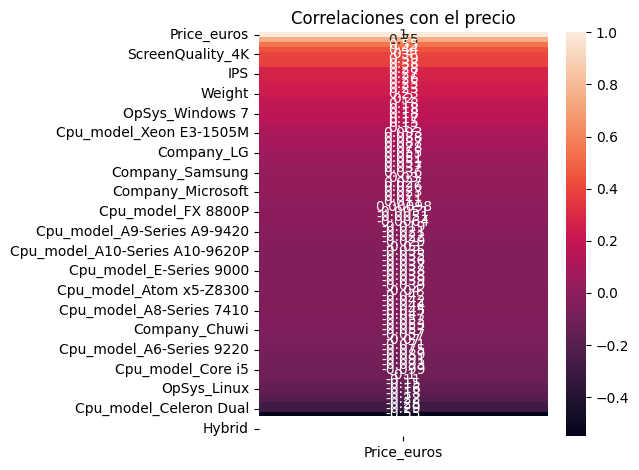

In [235]:
# ---- Dividir el dataset en entrenamiento y prueba ----
X = df.drop(columns=["Price_euros"])
y = df["Price_euros"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ---- Modelo de regresión ----
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# ---- Métricas ----
mae = mean_absolute_error(y_test, y_pred)  # Función de scikit-lear (y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("R² score:", r2)

# ---- Visualizaciones opcionales ----
sns.histplot(df["Price_euros"], kde=True)
plt.title("Distribución de precios")
plt.xlabel("Precio (€)")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

sns.heatmap(df.corr(numeric_only=True)[["Price_euros"]].sort_values(by="Price_euros", ascending=False), annot=True)
plt.title("Correlaciones con el precio")
plt.tight_layout()
plt.show()

### Características que contiene de forma conjunta la variable resolución.

- IPS es una tecnología de panel caracterizada por usar cristales líquidos alineados en paralelo que se intercalan entre 2 superficies de vidrio. Sus siglas significa "In-Plane Switching"
- La resolución Full HD, también conocida como FHD o 1080p, es una de las resoluciones más populares en la actualidad.
- Comenzaremos por la resolución HD, que significa Alta Definición. La resolución HD se refiere a una resolución de 1280x720 píxeles
- QHD: cuatro veces la resolución HD
La resolución QHD, también conocida como Quad HD o 2K, ofrece cuatro veces la resolución del HD estándar.
- UHD: Ultra alta definición
La resolución UHD, también conocida como Ultra Alta Definición o 4K, es la última evolución en calidad de imagen. Se refiere a una resolución de 3840x2160 píxeles, lo que significa que la pantalla tiene 3840 píxeles en el eje horizontal y 2160 píxeles en el eje vertica
- 4K: el estándar actual más común y de mejor calidad
El término 4K se utiliza comúnmente para referirse a la resolución UHD, ya que tiene aproximadamente 4000 píxeles en el eje horizontal.


### Notas de Comentario
Tenoendo en cuenta las diversas características que están de forma conjunta en la resolución, es conveniente hacer una mayor distinción en los tipos de resolución creando variables por separado para cada característica adicional a la dimensión de la resolución en si misma, es decir: Hd, Full HD, 4K, Quad , IPS Panel, Touchscreen.

Separar estas características o propiedades adicionales de la resolución en variables independientes nos permitirá capturar mejor el impacto de cada tecnología en el precio. Esto nos dará más flexibilidad al analizar cada factor por separado.. Sin embargo, en aras de explorar los posibles modelos, haremos pruebas tanto con la variable y sus características en resolución por separado y en conjunto. Dicho lo anterior:

Vamos a crear variables binarias (0 o 1) que representen la presencia de cada característica:
- HD (1 si la resolución es 1366x768 o 1600x900, 0 en caso contrario)
- Full HD (1920x1080)
- Quad HD+ (2560x1440 y 3200x1800)
- 4K Ultra HD (3840x2160)
- IPS Panel (Si contiene "IPS Panel" en el nombre)
- Touchscreen (Si contiene "Touchscreen")

Está claro que  no hay una relación lienal en tendencia respecto del precio y la resolución si consideramos la variable que muestra con todas sus características conjuntas. Podrían ser diversas las razones, es por ello que, haremos pruebas con la variable conjunta y las variables que hemos creado.

In [ ]:
print('MAE:', mean_absolute_error(y, linear_model.predict(X)))

pd_join = pd.DataFrame({'id': data_test['id'], 'Price_euros': predictions})
pd_join.to_csv('predictions.csv', index=False)
pd_join.head()

MAE: 216.5035893646738


,id,Price_euros
0,181,2242.559748
1,708,545.972267
2,862,300.021284
3,1064,1161.574306
4,702,679.161602


In [236]:
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge,Lasso,ElasticNet,RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score,root_mean_squared_error

In [239]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 729 entries, 25 to 102
Data columns (total 81 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Inches                          729 non-null    float64
 1   Ram                             729 non-null    int64  
 2   Weight                          729 non-null    float64
 3   HDD                             729 non-null    int64  
 4   SSD                             729 non-null    int64  
 5   Hybrid                          729 non-null    int64  
 6   Flash_Storage                   729 non-null    int64  
 7   Touchscreen                     729 non-null    int64  
 8   IPS                             729 non-null    int64  
 9   Cpu_speed_GHz                   679 non-null    float64
 10  Company_Apple                   729 non-null    bool   
 11  Company_Asus                    729 non-null    bool   
 12  Company_Chuwi                   729 non-

In [237]:
from sklearn import preprocessing

test_size = 0.20
random_seed = 42
RIDGE_alphas = np.logspace(-100, 100, 100)
LASSO_alphas = np.logspace(-100, 100, 100)
ELN_alphas = np.logspace(-100, 100, 100)


# Estandarización
std_scale= preprocessing.StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_test_std  = std_scale.transform(X_test)


# Ajustes
models = {
    "Ridge" : RidgeCV(alphas=RIDGE_alphas, cv=5),
    "Lasso" : LassoCV(alphas=LASSO_alphas, cv=5, max_iter=1000),
    "ElasticNet" : ElasticNetCV(alphas=ELN_alphas, l1_ratio=1,cv=5, max_iter=1000),
}


results_test = []
results_train = []


for name, model in models.items():
    model.fit(X_train_std, y_train)
    y_pred_train = model.predict(X_train_std)
    mae_train = mean_absolute_error(y, model.predict(X_train_std))
    results_train.append({"Modelo": name, 
                    "MAE": mae_train})
    

    
    y_pred = model.predict(X_test_std)
    



perf_df = (pd.DataFrame(results_train)
           .sort_values("MAE")
           .reset_index(drop=True))
print("\n── PERFORMANCE (variables estandarizadas-ENTRENAMIENTO) ──")
print(perf_df.to_string(index=False))

ValueError: 
All the 500 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
500 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\abela\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\abela\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\abela\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_ridge.py", line 1239, in fit
    X, y = validate_data(
           ~~~~~~~~~~~~~^
        self,
        ^^^^^
    ...<6 lines>...
        y_numeric=True,
        ^^^^^^^^^^^^^^^
    )
    ^
  File "c:\Users\abela\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py", line 2961, in validate_data
    X, y = check_X_y(X, y, **check_params)
           ~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\abela\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py", line 1370, in check_X_y
    X = check_array(
        X,
    ...<12 lines>...
        input_name="X",
    )
  File "c:\Users\abela\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py", line 1107, in check_array
    _assert_all_finite(
    ~~~~~~~~~~~~~~~~~~^
        array,
        ^^^^^^
    ...<2 lines>...
        allow_nan=ensure_all_finite == "allow-nan",
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "c:\Users\abela\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py", line 120, in _assert_all_finite
    _assert_all_finite_element_wise(
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^
        X,
        ^^
    ...<4 lines>...
        input_name=input_name,
        ^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "c:\Users\abela\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py", line 169, in _assert_all_finite_element_wise
    raise ValueError(msg_err)
ValueError: Input X contains NaN.
Ridge does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


In [44]:
# Seleccionamos el mejor
best_name  = perf_df.loc[0, "Modelo"]
best_model = models[best_name]
beta_std   = pd.Series(best_model.coef_, index=X.columns)
b0_std     = best_model.intercept_

print(f"\n► Mejor modelo: {best_name}")
print("Coeficientes (β_std):")
print(beta_std.round(3))
print(f"Intercepto (β₀_std): {b0_std:.3f}\n")

KeyError: 'Ridge'

In [36]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [43]:
modelos = {
    'ridge': Ridge(),
    'lasso': Lasso(),
    'elasticnet': ElasticNet(),
    'random_forest': RandomForestRegressor(random_state=42)
}

# Grid para hiperparámetros
param_grid = {
    'ridge': {'model__alpha': [0.1, 1.0, 10.0]},
    'lasso': {'model__alpha': [0.01, 0.1, 1.0]},
    'elasticnet': {'model__alpha': [0.01, 0.1, 1.0], 'model__l1_ratio': [0.1, 0.5, 0.9]},
    'random_forest': {'model__n_estimators': [50, 100], 'model__max_depth': [None, 5]}
}


# Estandarización
std_scale= preprocessing.StandardScaler().fit(X)
X_train_std = std_scale.transform(X)
std_scale_test= preprocessing.StandardScaler().fit(X_test)
X_test_std  = std_scale_test.transform(X_test)

ValueError: could not convert string to float: 'Dell'

In [38]:
resultados = {}
for nombre, modelo in modelos.items():
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', modelo)
    ])
    
    print(f" Entrenando modelo: {nombre}")
    
    grid = GridSearchCV(pipe, param_grid[nombre], cv=10, scoring='neg_mean_squared_error')
    grid.fit(X_train_std, y)

    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test_std)

    mae_train = mean_absolute_error(y, best_model.predict(X_train_std))
    print(f"✅ MAE_Train {nombre}: {mae_train:.2f} | Mejores hiperparámetros: {grid.best_params_}")

    pred_df = pd.DataFrame({
        'id': data_test.id.values,
        'Price_euros': y_pred
    }).sort_values('id')

    resultados[nombre] = pred_df

    # Guardar CSV
    pred_df.to_csv(f'CVpredicciones_{nombre}.csv', index=False)

 Entrenando modelo: ridge
✅ MAE_Train ridge: 216.28 | Mejores hiperparámetros: {'model__alpha': 10.0}
 Entrenando modelo: lasso


c:\Users\abela\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.795e+05, tolerance: 3.897e+04
  model = cd_fast.enet_coordinate_descent(
c:\Users\abela\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.817e+06, tolerance: 4.304e+04
  model = cd_fast.enet_coordinate_descent(
c:\Users\abela\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

✅ MAE_Train lasso: 216.49 | Mejores hiperparámetros: {'model__alpha': 1.0}
 Entrenando modelo: elasticnet


c:\Users\abela\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.492e+06, tolerance: 3.897e+04
  model = cd_fast.enet_coordinate_descent(
c:\Users\abela\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.217e+06, tolerance: 4.304e+04
  model = cd_fast.enet_coordinate_descent(
c:\Users\abela\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

✅ MAE_Train elasticnet: 216.50 | Mejores hiperparámetros: {'model__alpha': 1.0, 'model__l1_ratio': 0.9}
 Entrenando modelo: random_forest
✅ MAE_Train random_forest: 91.67 | Mejores hiperparámetros: {'model__max_depth': None, 'model__n_estimators': 100}


In [39]:
df = pd.read_csv("train.csv")
df
# Separar predictores y variable objetivo
X = df.drop(columns=['id', 'laptop_ID','Price_euros'])
y = df['Price_euros']

data_test = pd.read_csv("test.csv")
X_test = data_test.drop(columns=['id', 'laptop_ID'])


In [83]:
import numpy as np
import pandas as pd

# Importación de librerías de scikit-learn
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error

# Importación de modelos de regresión
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb

# =============================================================================
# 1. Carga de datos
# =============================================================================

# Supongamos que tus datos están en archivos CSV:
# "train.csv" contiene la variable target y las covariables
# "test.csv" contiene solo las covariables (sin target)

#train_df = X  # Asegúrate de que incluya la columna 'target'
#test_df = X_test    # Este DF no debe tener la columna 'target'

# Separar covariables y target en los datos de entrenamiento
X_train = X
y_train = y

# Datos de prueba: solo covariables
X_test = X_test

# =============================================================================
# 2. Definición de modelos y grids de hiperparámetros
# =============================================================================

# Diccionario con los 4 modelos a evaluar
models = {
    "AdaBoost": AdaBoostRegressor(random_state=42),
    "XGBoost": xgb.XGBRegressor(objective="reg:squarederror", random_state=42, verbosity=0),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
    "LightGBM": lgb.LGBMRegressor(random_state=42,)
}

# Parámetros a buscar para cada modelo dentro del pipeline (el prefijo 'regressor__' es necesario)
param_grids = {
    "AdaBoost": {
        "regressor__n_estimators": [30,35, 150, 100, 200],
        "regressor__learning_rate": [0.01, 0.1, 1.0]
    },
    "XGBoost": {
        "regressor__n_estimators": [30,35, 150, 100, 200],
        "regressor__learning_rate": [0.01, 0.1, 0.2],
        "regressor__max_depth": [3, 5, 7]
    },
    "GradientBoosting": {
        "regressor__n_estimators": [30,35, 150, 100, 200],
        "regressor__learning_rate": [0.01, 0.1, 0.2],
        "regressor__max_depth": [3, 5, 7]
    },
    "LightGBM": {
        "regressor__n_estimators": [30, 35, 150, 100, 200],
        "regressor__learning_rate": [0.01, 0.1, 0.2],
        "regressor__max_depth": [3, 5, 7]
    }
}

# =============================================================================
# 3. Pipeline, búsqueda de hiperparámetros y validación cruzada
# =============================================================================

# Diccionarios para almacenar los resultados y los mejores modelos encontrados
results = {}
best_models = {}

# Para cada modelo, se crea un pipeline que primero estandariza los datos y luego ajusta el modelo.
# Se realiza una búsqueda de hiperparámetros usando GridSearchCV y la métrica "Mean Absolute Error" (MAE)
for name, model in models.items():
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("regressor", model)
    ])
    
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grids[name],
        scoring="neg_mean_absolute_error",  # Se usa el negativo porque scikit‑learn maximiza la puntuación
        cv=5,
        n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)
    
    # Se almacena el mejor pipeline y el error obtenido en validación cruzada (convierte a positivo)
    best_models[name] = grid_search.best_estimator_
    results[name] = {
        "Best_Params": grid_search.best_params_,
        "CV_MAE": -grid_search.best_score_
    }
    print(f"{name} completado. MAE (CV): {-grid_search.best_score_:.4f}")

# Mostramos la comparación de modelos según el MAE obtenido en validación cruzada
results_df = pd.DataFrame(results).T
print("\nComparación de modelos (CV MAE):")
print(results_df)

# =============================================================================
# 4. Selección del mejor modelo y predicción en el conjunto de prueba
# =============================================================================

# Se selecciona el modelo con el menor MAE en validación cruzada
best_model_name = min(results, key=lambda name: results[name]["CV_MAE"])
best_model = best_models[best_model_name]
print(f"\nEl mejor modelo es: {best_model_name} con CV MAE: {results[best_model_name]['CV_MAE']:.4f}")

# Una vez seleccionado, se usan todos los datos de entrenamiento para ajustar (ya se hizo dentro de GridSearchCV)
# y se realiza la predicción sobre el conjunto de prueba
test_predictions = best_model.predict(X_test)

# Se pueden guardar las predicciones en un archivo CSV para su posterior análisis o entrega




AdaBoost completado. MAE (CV): 285.0003
XGBoost completado. MAE (CV): 199.3199
GradientBoosting completado. MAE (CV): 198.4238
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000686 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 202
[LightGBM] [Info] Number of data points in the train set: 912, number of used features: 28
[LightGBM] [Info] Start training from score 1108.122872
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warni

In [81]:
pred_df = pd.DataFrame({
        'id': data_test.id.values,
        'Price_euros': test_predictions
    }).sort_values('id')



    # Guardar CSV
pred_df.to_csv(f'Boostingx_predicciones_{best_model_name}.csv', index=False)


In [82]:
best_models

{'AdaBoost': Pipeline(steps=[('scaler', StandardScaler()),
                 ('regressor',
                  AdaBoostRegressor(learning_rate=0.01, n_estimators=35,
                                    random_state=42))]),
 'XGBoost': Pipeline(steps=[('scaler', StandardScaler()),
                 ('regressor',
                  XGBRegressor(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None